<a href="https://colab.research.google.com/github/iaksaurya/stock_price_prediction/blob/main/stockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

dir = "/content/drive/MyDrive/stockPricePrediction"

In [2]:
#https://aroussi.com/post/python-yahoo-finance
# !nvidia-smi

In [5]:
!pip install --upgrade yfinance

In [6]:
!pip install transformers torch

In [7]:
# 1. Install the downloader library
!pip install opendatasets --upgrade --quiet


In [8]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

In [9]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.7 MB/s eta 0:00:00


In [10]:
#final_path = os.path.join(dir, "massive-stock-news-analysis-db-for-nlpbacktests", "raw_analyst_ratings.csv")
# 1. SETUP: Define file path
final_path = dir +"/aapl_large_news.csv"

In [11]:
df_csv = pd.read_csv(final_path)


In [12]:
df_csv.head()

,Date,Title,Sentiment
0,1999-09-01,"Компания Apple выпустила ""настольный суперкомп...",0
1,1999-10-06,Apple выпустила новый iMac,0
2,1999-11-09,Компания Apple снова выиграла дело о компьютер...,0
3,1999-12-07,Японские власти обыскали штаб-квартиру Apple,0
4,2000-08-07,"Суд обязал Yahoo разоблачить пользователя, раз...",0


In [13]:
import pandas as pd

# Load the huge CSV
print("Loading Dataset...")
#dir2 = "/content/drive/MyDrive/stockPricePrediction/raw_analyst_ratings.csv"
df_csv = pd.read_csv(final_path)

#  Filter for  Stock (e.g., 'A' usually stands for Agilent, ensure you find AAPL)
# Note: This dataset uses Ticker symbols.
#df_aapl = df_csv[df_csv['stock'] == 'AAPL'].copy()
df_aapl=df_csv.copy()

#  Clean the Dates (The raw file has timezone info like "-04:00"
# Parse date strings using 'mixed' format to handle variations, coercing errors to NaT.
# Using utc=True as suggested by the FutureWarning and for consistent timezone handling.
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'], format='mixed', errors='coerce', utc=True)

# Ensure the column is actually datetime-like before applying .dt accessor methods.
if pd.api.types.is_datetime64_any_dtype(df_aapl['Date']):
    # Convert to timezone-naive (remove timezone information).
    # .dt.tz_convert(None) is a robust way to achieve this for timezone-aware data.
    df_aapl['Date'] = df_aapl['Date'].dt.tz_convert(None)

    # Normalize the datetime to the start of the day (00:00:00) to represent just the date.
    df_aapl['Date'] = df_aapl['Date'].dt.normalize()
else:
    # If the column is not datetime-like, it means parsing failed for all entries.
    # In this case, the column will likely be an object Series with NaT values.
    # No further .dt operations can be performed.
    print("Warning: 'date' column could not be entirely converted to datetime objects. Some operations skipped.")

# The columns are already named 'Date' and 'Title', so no renaming is needed for this dataset.
# df_aapl = df_aapl.rename(columns={'headline': 'Title', 'date': 'Date'})

#  NOW calculate sentiment on this historical data
# (Feed this 'df_aapl' into your FinBERT function)
print(df_aapl[['Date', 'Title']].head())

Loading Dataset...
        Date                                              Title
0 1999-09-01  Компания Apple выпустила "настольный суперкомп...
1 1999-10-06                         Apple выпустила новый iMac
2 1999-11-09  Компания Apple снова выиграла дело о компьютер...
3 1999-12-07       Японские власти обыскали штаб-квартиру Apple
4 2000-08-07  Суд обязал Yahoo разоблачить пользователя, раз...


In [14]:
df_aapl.head()

,Date,Title,Sentiment
0,1999-09-01,"Компания Apple выпустила ""настольный суперкомп...",0
1,1999-10-06,Apple выпустила новый iMac,0
2,1999-11-09,Компания Apple снова выиграла дело о компьютер...,0
3,1999-12-07,Японские власти обыскали штаб-квартиру Apple,0
4,2000-08-07,"Суд обязал Yahoo разоблачить пользователя, раз...",0


In [15]:
df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10000 non-null  datetime64[ns]
 1   Title      10000 non-null  object        
 2   Sentiment  10000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 234.5+ KB


In [16]:
import pandas as pd
from transformers import pipeline
import os


print(f" Raw Data Rows: {len(df_aapl)}")



# -- RUN AI SENTIMENT (With Caching) ---
CACHE_FILE = dir+"/aapl_historical_sentiment.csv"


if os.path.exists(CACHE_FILE):
    print(f" Loading processed sentiment from '{CACHE_FILE}'...")
    df_final_sentiment = pd.read_csv(CACHE_FILE)
    df_final_sentiment['Date'] = pd.to_datetime(df_final_sentiment['Date'])
else:
    print(" Starting AI Analysis (This will take time)...")

    # Load FinBERT
    finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert", device=0) # device=0 if have GPU

    # Define a fast processing function
    def get_sentiment(text):
        try:
            # Truncate text to 512 chars to prevent errors
            result = finbert(text[:512])[0]
            if result['label'] == 'positive': return result['score']
            if result['label'] == 'negative': return -result['score']
            return 0
        except:
            return 0

    # Apply to the dataframe
    # TIP: For testing, use .head(100) first! Remove .head(100) to run all data.
    df_aapl['Sentiment'] = df_aapl['Title'].apply(get_sentiment)

    # Save the valuable result
    df_aapl.to_csv(CACHE_FILE, index=False)
    df_final_sentiment = df_aapl

print("\n---  READY FOR MERGE ---")
print(df_final_sentiment[['Date', 'Sentiment']].head())

 Raw Data Rows: 10000
 Starting AI Analysis (This will take time)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



---  READY FOR MERGE ---
        Date  Sentiment
0 1999-09-01        0.0
1 1999-10-06        0.0
2 1999-11-09        0.0
3 1999-12-07        0.0
4 2000-08-07        0.0


In [17]:
df_final_sentiment.count()

,0
Date,10000
Title,10000
Sentiment,10000


In [18]:
df_final_sentiment.head()

,Date,Title,Sentiment
0,1999-09-01,"Компания Apple выпустила ""настольный суперкомп...",0.0
1,1999-10-06,Apple выпустила новый iMac,0.0
2,1999-11-09,Компания Apple снова выиграла дело о компьютер...,0.0
3,1999-12-07,Японские власти обыскали штаб-квартиру Apple,0.0
4,2000-08-07,"Суд обязал Yahoo разоблачить пользователя, раз...",0.0


In [19]:
df_final_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10000 non-null  datetime64[ns]
 1   Title      10000 non-null  object        
 2   Sentiment  10000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 234.5+ KB


In [20]:
import yfinance as yf

#  AGGREGATE: Calculate the Average Daily Sentiment
# If June 10 has 3 articles (+0.9, -0.1, +0.4), the Score becomes +0.4
daily_sentiment = df_final_sentiment.groupby('Date')['Sentiment'].mean().reset_index()

print(" Daily Sentiment Summary:")
print(daily_sentiment.head())

#  FETCH PRICES: Get AAPL stock data for the same period
# We pad the start/end dates slightly to ensure we cover all news
min_date = daily_sentiment['Date'].min()
max_date = daily_sentiment['Date'].max()

print(f"\n Fetching Prices from {min_date} to {max_date}...")
df_prices = yf.download("AAPL", start=min_date, end=max_date)
df_prices.reset_index(inplace=True)

# FIX: Flatten the MultiIndex columns of df_prices
# yfinance often returns MultiIndex columns (e.g., ('Close', 'AAPL'))
# We need to flatten them to a single level for merging
df_prices.columns = df_prices.columns.get_level_values(0)

#  CLEAN DATES: Ensure both are strict 'YYYY-MM-DD' format
df_prices['Date'] = pd.to_datetime(df_prices['Date']).dt.date
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date']).dt.date

#  MERGE: Combine Price + Sentiment
# how='left' means: Keep all price days, add sentiment where available
final_df = pd.merge(df_prices, daily_sentiment, on='Date', how='left')

#  FILL GAPS: Days with no news get 0 (Neutral)
final_df['Sentiment'] = final_df['Sentiment'].fillna(0)

print("\n FINAL DATASET READY FOR TRAINING:")
print(final_df[['Date', 'Close', 'Sentiment']].head(10))

 Daily Sentiment Summary:
        Date  Sentiment
0 1999-09-01        0.0
1 1999-10-06        0.0
2 1999-11-09        0.0
3 1999-12-07        0.0
4 2000-08-07        0.0

 Fetching Prices from 1999-09-01 00:00:00 to 2020-06-11 00:00:00...


/tmp/ipython-input-3419629234.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_prices = yf.download("AAPL", start=min_date, end=max_date)
[*********************100%***********************]  1 of 1 completed


 FINAL DATASET READY FOR TRAINING:
         Date     Close  Sentiment
0  1999-09-01  0.514534        0.0
1  1999-09-02  0.529061        0.0
2  1999-09-03  0.551085        0.0
3  1999-09-07  0.572642        0.0
4  1999-09-08  0.558584        0.0
5  1999-09-09  0.566550        0.0
6  1999-09-10  0.580608        0.0
7  1999-09-13  0.562332        0.0
8  1999-09-14  0.583419        0.0
9  1999-09-15  0.565144        0.0


In [21]:
final_df.head()

,Date,Close,High,Low,Open,Volume,Sentiment
0,1999-09-01,0.514534,0.515939,0.494852,0.502350,788625600,0.0
1,1999-09-02,0.529061,0.535622,0.501413,0.507036,895148800,0.0
2,1999-09-03,0.551085,0.564207,0.528592,0.539370,1635267200,0.0
3,1999-09-07,0.572642,0.584357,0.551085,0.552960,984793600,0.0
4,1999-09-08,0.558584,0.582482,0.558584,0.571236,762204800,0.0


In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5227 entries, 0 to 5226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5227 non-null   object 
 1   Close      5227 non-null   float64
 2   High       5227 non-null   float64
 3   Low        5227 non-null   float64
 4   Open       5227 non-null   float64
 5   Volume     5227 non-null   int64  
 6   Sentiment  5227 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 286.0+ KB


In [23]:
# Check how many headlines contributed to each day's score
news_volume = df_aapl.groupby('Date').size()

print("--- Headlines Per Day (Top 5) ---")
print(news_volume.head())

print(f"\nTotal Headlines: {news_volume.sum()} (Should be 441)")
print(f"Total Days: {len(news_volume)} (Should be close to 65)")

--- Headlines Per Day (Top 5) ---
Date
1999-09-01    1
1999-10-06    1
1999-11-09    1
1999-12-07    1
2000-08-07    1
dtype: int64

Total Headlines: 10000 (Should be 441)
Total Days: 2775 (Should be close to 65)


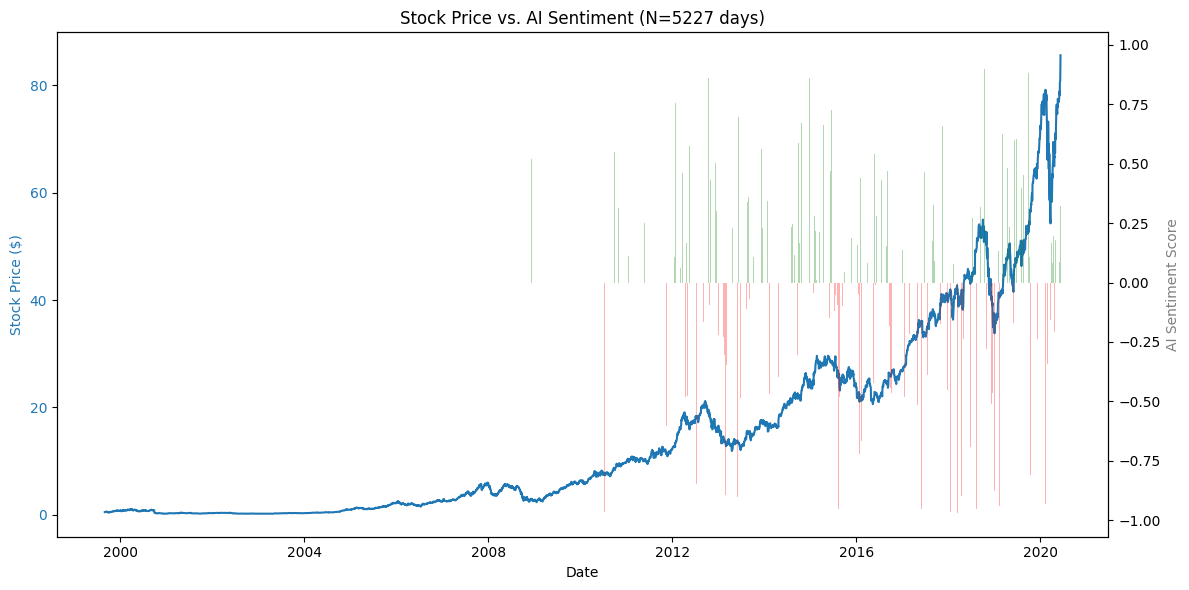

In [24]:
import matplotlib.pyplot as plt

# 1. SETUP: Ensure dates are sorted for plotting
final_df = final_df.sort_values('Date')

# 2. CREATE PLOT
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Stock Price (Left Axis)
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price ($)', color='tab:blue')
ax1.plot(final_df['Date'], final_df['Close'], color='tab:blue', label='Stock Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second axis for Sentiment (Right Axis)
ax2 = ax1.twinx()
ax2.set_ylabel('AI Sentiment Score', color='tab:gray')

# Plot Sentiment as Bars
# Green for Positive (>0), Red for Negative (<0)
colors = ['g' if s > 0 else 'r' for s in final_df['Sentiment']]
ax2.bar(final_df['Date'], final_df['Sentiment'], color=colors, alpha=0.3, width=1, label='News Sentiment')

# 3. FINALIZE
plt.title(f'Stock Price vs. AI Sentiment (N={len(final_df)} days)')
fig.tight_layout()
plt.show()

Big Green Bars: Did the stock price (Blue Line) go UP the next day?

Big Red Bars: Did the stock price go DOWN?

Flat/Small Bars:  found the news "Neutral" or irrelevant.

In [25]:
#  Save the final dataset
final_training=dir+"/final_training_data.csv"
final_df.to_csv(final_training, index=False)
print("Saved 'final_training_data.csv' successfully.")

#  Quick Preview of what the model will learn from
# We want to see if the Sentiment is changing (not just 0.0 everywhere)
print("\n--- Data Preview ---")
print(final_df[['Date', 'Close', 'Sentiment']].head())

# Check if we have enough non-zero sentiment days
non_zero = final_df[final_df['Sentiment'] != 0].shape[0]
print(f"\nDays with Real News Sentiment: {non_zero}/{len(final_df)}")

Saved 'final_training_data.csv' successfully.

--- Data Preview ---
         Date     Close  Sentiment
0  1999-09-01  0.514534        0.0
1  1999-09-02  0.529061        0.0
2  1999-09-03  0.551085        0.0
3  1999-09-07  0.572642        0.0
4  1999-09-08  0.558584        0.0

Days with Real News Sentiment: 1104/5227


 Training Shape: (4101, 100, 4)
 Testing Shape: (1026, 100, 4)
 Training LSTM... (This may take a minute)
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0019
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.9103e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.1411e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.7853e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 1.4520e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.3033e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.4238e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.2336e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2156e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.2637e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0582e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1058e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0525e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0809e-04
Ep

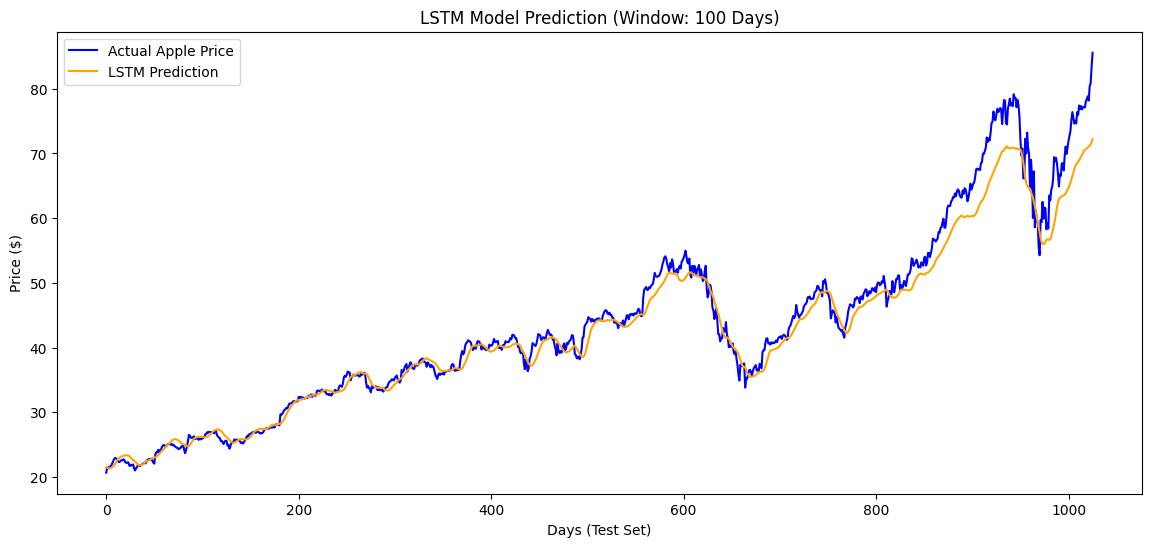

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#  LOAD DATA
df = pd.read_csv(final_training)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Select Features: We use Close, Sentiment, Open, and Volume
# Note: 'Close' must be the first column because we want to predict it later
features = ['Close', 'Sentiment', 'Open', 'Volume']
data = df[features].values

# SCALING (Crucial for LSTM)
# LSTMs fail if data isn't between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

#  CREATE SEQUENCES (The "Window" Approach)
# We don't just feed 1 row. We feed a "window" of 60 days to predict the 61st.
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i]) # Past 60 days (all features)
        y.append(data[i, 0])            # The next day's 'Close' price (column 0)
    return np.array(X), np.array(y)

WINDOW_SIZE = 100
X, y = create_sequences(scaled_data, WINDOW_SIZE)

# Split into Train (80%) and Test (20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f" Training Shape: {X_train.shape}")
print(f" Testing Shape: {X_test.shape}")

#  BUILD THE LSTM MODEL
model = Sequential()

# Layer 1: LSTM with 50 neurons, return_sequences=True (to stack another LSTM)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) # Prevents overfitting

# Layer 2: LSTM with 50 neurons, no return_sequences (final LSTM layer)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer 3: Output Layer (Predicts 1 value: Price)
model.add(Dense(units=1))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. TRAIN THE MODEL
print(" Training LSTM... (This may take a minute)")
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 6. MAKE PREDICTIONS
predicted_prices = model.predict(X_test)

# 7. INVERSE SCALING (Get back to Real Prices)
# We scaled ALL features (Close, Sentiment, etc.), but we only predicted 'Close'.
# We need to construct a dummy array to inverse transform correctly.

# Create a placeholder filled with zeros
dummy_array = np.zeros((len(predicted_prices), len(features)))
# Put our predicted prices into the first column (Close)
dummy_array[:, 0] = predicted_prices.flatten()
# Inverse transform
actual_predicted_prices = scaler.inverse_transform(dummy_array)[:, 0]

# Do the same for Real Prices (y_test) to compare
dummy_y_test = np.zeros((len(y_test), len(features)))
dummy_y_test[:, 0] = y_test
actual_real_prices = scaler.inverse_transform(dummy_y_test)[:, 0]

# 8. VISUALIZE
plt.figure(figsize=(14, 6))
plt.plot(actual_real_prices, color='blue', label='Actual Apple Price')
plt.plot(actual_predicted_prices, color='orange', label='LSTM Prediction')
plt.title(f'LSTM Model Prediction (Window: {WINDOW_SIZE} Days)')
plt.xlabel('Days (Test Set)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [32]:
import gradio as gr
import requests

# --- Configuration ---
DEFAULT_API_KEY = "66a53077f85c4a6982d62583c4ee676d"

# --- Logic ---
def get_news_html(api_key):
    """
    Fetches news and converts it into a responsive HTML grid for Gradio.
    """
    if not api_key:
        return "<p style='color:red;'>Please enter a valid API Key.</p>"

    url = f"https://newsapi.org/v2/top-headlines?category=business&language=en&apiKey={api_key}"

    try:
        response = requests.get(url)
        data = response.json()

        if data.get('status') != 'ok':
            return f"<p style='color:red;'>Error from API: {data.get('message', 'Unknown error')}</p>"

        articles = data.get('articles', [])

        if not articles:
            return "<p>No articles found.</p>"

        # Build HTML Grid
        html_content = '<div class="news-container">'

        for article in articles[:10]: # Show top 10 articles
            # Safe extraction with fallbacks
            source = article.get('source', {}).get('name', 'Unknown Source')
            title = article.get('title', 'No Title')
            link = article.get('url', '#')
            image = article.get('urlToImage')
            description = article.get('description', '')

            # Placeholder image if none exists
            if not image:
                image = "https://via.placeholder.com/400x200?text=No+Image+Available"

            # Create the Card HTML
            html_content += f"""
            <div class="news-card">
                <div class="card-image" style="background-image: url('{image}');"></div>
                <div class="card-content">
                    <div class="card-source">{source}</div>
                    <a href="{link}" target="_blank" class="card-title">{title}</a>
                    <p class="card-desc">{description if description else "No description available."}</p>
                    <a href="{link}" target="_blank" class="read-more">Read Article ↗</a>
                </div>
            </div>
            """

        html_content += '</div>'
        return html_content

    except Exception as e:
        return f"<p style='color:red;'>System Error: {str(e)}</p>"

# --- Styling (CSS) ---
# This CSS creates the responsive grid layout and styles the cards
custom_css = """
.news-container {
    display: grid;
    grid-template-columns: repeat(auto-fill, minmax(300px, 1fr));
    gap: 25px;
    padding: 10px;
}

.news-card {
    background-color: var(--background-fill-secondary);
    border: 1px solid var(--border-color-primary);
    border-radius: 12px;
    overflow: hidden;
    transition: transform 0.3s ease, box-shadow 0.3s ease;
    display: flex;
    flex-direction: column;
}

.news-card:hover {
    transform: translateY(-5px);
    box-shadow: 0 10px 20px rgba(0,0,0,0.1);
}

.card-image {
    height: 180px;
    width: 100%;
    background-size: cover;
    background-position: center;
    background-color: #e0e0e0;
}

.card-content {
    padding: 20px;
    display: flex;
    flex-direction: column;
    flex-grow: 1;
}

.card-source {
    font-size: 0.8rem;
    color: #ff4b4b; /* Streamlit/Gradio Red accent */
    text-transform: uppercase;
    letter-spacing: 1px;
    font-weight: bold;
    margin-bottom: 8px;
}

.card-title {
    font-size: 1.1rem;
    font-weight: 700;
    color: var(--body-text-color);
    text-decoration: none;
    margin-bottom: 10px;
    line-height: 1.4;
}

.card-title:hover {
    color: #ff4b4b;
}

.card-desc {
    font-size: 0.9rem;
    color: var(--body-text-color-subdued);
    margin-bottom: 20px;
    flex-grow: 1;
    line-height: 1.5;
    display: -webkit-box;
    -webkit-line-clamp: 3;
    -webkit-box-orient: vertical;
    overflow: hidden;
}

.read-more {
    margin-top: auto;
    text-decoration: none;
    color: var(--link-text-color);
    font-weight: 600;
    font-size: 0.9rem;
}

.read-more:hover {
    text-decoration: underline;
}
"""

# --- Gradio App ---
with gr.Blocks(css=custom_css, title="Financial News") as demo:

    with gr.Row():
        gr.Markdown("# 📈 Business & Financial Headlines")

    with gr.Row():
        with gr.Column(scale=4):
            api_input = gr.Textbox(
                value=DEFAULT_API_KEY,
                label="NewsAPI Key",
                type="password",
                placeholder="Enter your NewsAPI key here"
            )
        with gr.Column(scale=1):
            # Using a variant='primary' makes the button stand out
            refresh_btn = gr.Button("🔄 Fetch News", variant="primary", scale=1)

    # The container where our HTML grid will render
    news_display = gr.HTML(label="News Feed")

    # Trigger the function when button is clicked
    refresh_btn.click(fn=get_news_html, inputs=api_input, outputs=news_display)

    # Also load news immediately on launch
    demo.load(fn=get_news_html, inputs=api_input, outputs=news_display)

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://357063d0233787e654.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
